# Для запуска в Google Colab

Раскомментируйте команды ниже для запуска в Colab. Код был протестирован с Python 3.8 и PyTorch 1.8 CUDA 11.

**После установки зависимостей необходим перезапуск окружения** 

In [ ]:
# !apt install -y  git-lfs
# !git lfs version

In [ ]:
# %cd /content

In [ ]:
# !if [ ! -d ./made-adv-ml-hw2 ]; then git clone -b colab-branch --depth 1 --single-branch https://github.com/KernelA/made-adv-ml-hw2.git; fi

In [ ]:
# %cd /content/made-adv-ml-hw2

In [ ]:
# !git lfs pull

In [ ]:
# !pip install -r ./requirements.txt

In [ ]:
# !if [ -f ./.dvc/tmp/rwlock ]; then rm ./.dvc/tmp/rwlock; fi

In [ ]:
# !dvc repro train_test_split

In [1]:
import pathlib
import pickle
import shutil
import random

import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model
from scipy import sparse
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

plt.style.use("ggplot")
mpl.rcParams["figure.figsize"] = (10, 10)

In [2]:
np.random.seed(12)
random.seed(22)
torch.manual_seed(0)
torch.set_default_dtype(torch.float64)

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
from rating_model import TeamResults
from rating_model import PICKLE_PROTOCOL
from rating_model import EMRatingModel, get_player_skills, estimate_rank
from utils import load_pickle, dump_pickle, optimize_dataframe_numeric_dtypes

# 1 Предобработка данных

Основная логика предоработки данных содержится в .py файлах проекта.

In [5]:
tours_datapath = pathlib.Path("data", "pickle_data", "tournaments-dt.pickle")

In [6]:
tours = pd.read_pickle(tours_datapath)

In [7]:
players_datapath = pathlib.Path("data", "pickle_data", "players-dt.pickle")

In [8]:
players_info = pd.read_pickle(players_datapath)

In [9]:
team_res_datapath = pathlib.Path(
    "data", "team_res", "train_team_results.pickle")

In [10]:
team_res = load_pickle(team_res_datapath)

In [11]:
total_unknown_team_players = 0
total_unknown_answers = 0
for tour_id in team_res.tours:
    for team_id in team_res[tour_id]:
        team = team_res[tour_id][team_id]
        if not team.members:
            total_unknown_team_players += 1
        if not team.mask:
            total_unknown_answers += 1

In [12]:
print("Количество команд без состава команды: ", total_unknown_team_players,
      "Количество команд с неизвестными повопроснами результатами: ", total_unknown_answers, sep="\n")

Количество команд без состава команды: 
69
Количество команд с неизвестными повопроснами результатами: 
173


In [13]:
tours.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1105 entries, 4628 to 6485
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   name          1105 non-null   object             
 1   dateStart     1105 non-null   datetime64[ns, UTC]
 2   dateEnd       1105 non-null   datetime64[ns, UTC]
 3   type          1105 non-null   object             
 4   season        1015 non-null   object             
 5   orgcommittee  1105 non-null   object             
 6   synchData     669 non-null    object             
 7   questionQty   1105 non-null   object             
dtypes: datetime64[ns, UTC](2), object(6)
memory usage: 77.7+ KB


In [14]:
players_dump = pathlib.Path("dump", "players.pickle")
players_dump.parent.mkdir(exist_ok=True, parents=True)

In [15]:
force_get_players = False

In [16]:
players = None

In [17]:
if not players_dump.exists() or force_get_players:
    players = team_res.to_player_dataframe(filter_by_mask=True)
    optimize_dataframe_numeric_dtypes(players)
    dump_pickle(players_dump, players)
else:
    players = load_pickle(players_dump)

In [18]:
assert players.index.is_monotonic_increasing

In [19]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17823516 entries, 0 to 17823515
Data columns (total 5 columns):
 #   Column           Dtype
---  ------           -----
 0   tour_id          int16
 1   team_id          int32
 2   player_id        int32
 3   answer_id        int32
 4   is_right_answer  bool 
dtypes: bool(1), int16(1), int32(3)
memory usage: 255.0 MB


In [20]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [21]:
target = players["is_right_answer"].astype(np.int8).to_numpy()

## 2 Построение логистической регрессии для ранжирования игроков

Пусть параметры модели образуют составляют вектор $w = \left(s_1,s_2,\ldots,s_P, c_1, c_2, \ldots, c_A, b \right)^T,$ где $P-$ общее число игроков, $A-$ общее число вопросов. Таким образом значения параметров будут обозначать "силы игроков" $s_i, i=1,\ldots,P$ и сложнности вопросов $c_j, j=1,\ldots,A$, $b$- глоабальный коэффициент смещения/

Распредление ответов по всем игрокам:

<AxesSubplot:>

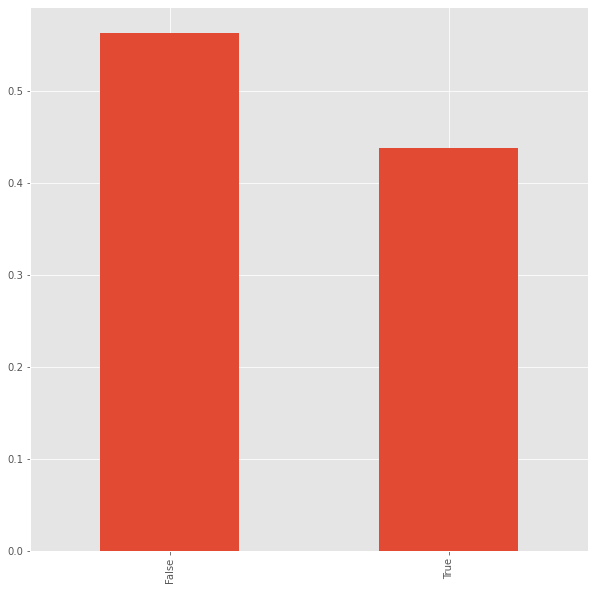

In [22]:
players["is_right_answer"].value_counts(normalize=True).plot.bar()

In [23]:
feature_dtype = np.float64

In [24]:
skils_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)

In [25]:
skils_features_one_hot = skils_encoder.fit_transform(
    players["player_id"].to_numpy().reshape(-1, 1))

In [26]:
questione_complex_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)

In [27]:
question_complices_one_hot = questione_complex_encoder.fit_transform(
    players["answer_id"].to_numpy().reshape(-1, 1))

In [28]:
features = sparse.hstack(
    (skils_features_one_hot, question_complices_one_hot), format="csr")
del skils_features_one_hot
del question_complices_one_hot

In [29]:
assert sparse.isspmatrix_csr(features)

In [30]:
features

<17823516x91209 sparse matrix of type '<class 'numpy.float64'>'
	with 35647032 stored elements in Compressed Sparse Row format>

In [31]:
dump_model_filepath = pathlib.Path("model", "log-reg")

In [32]:
dump_model_filepath.mkdir(parents=True, exist_ok=True)

In [33]:
force_train = False

In [34]:
model_dump = dump_model_filepath / "log-reg.pickle"

In [35]:
regression = None

In [36]:
if not force_train and model_dump.exists():
    regression = load_pickle(model_dump)

In [37]:
if regression is None:
    regression = linear_model.LogisticRegression(
        penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=10, fit_intercept=True)
    regression.fit(features, target)
    dump_pickle(model_dump, regression)

### Рейтинг игроков

Сравним позиции игроков на основе рейтингов с реальными позициями на момент [26 декабря 2019 (выгрузка содержит только первые 1000 записей)](https://rating.chgk.info/players.php?release=1429&surname=&name=&patronymic=&idplayer=28751&town=&search=%D0%98%D1%81%D0%BA%D0%B0%D1%82%D1%8C)

In [38]:
path_to_real_ratings = pathlib.Path(
    "data", "raw_data", "players-release-2019-12-26.csv")

In [39]:
top_n = 10

In [40]:
real_data = pd.read_csv(path_to_real_ratings, usecols=[
                        "id", "Место"], index_col="id", nrows=top_n)

In [41]:
player_ratings = get_player_skills(skils_encoder, regression.coef_[0])
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [42]:
player_ratings[:top_n].join(real_data)

,skill,Место
27403,3.096479,5.0
4270,2.959321,6.0
28751,2.906861,2.0
27822,2.818143,3.0
30270,2.746775,4.0
40411,2.744969,NaN
30152,2.734100,1.0
38175,2.674778,NaN
20691,2.636272,NaN
199963,2.598878,NaN


В результате часть игроков, попавшие в топ из реального рейтинга совпали с результатом ранжирования после обучения логистической регрессии, но их позиции точно не совпали. Существуют игроки, которых не было в реальном рейтинге топ-1000. 

## 3 Оценка результатов

Для сравнение команд воспользуемся простым правилом. Для каждой команды в турнире возьмём игроков в отсортированном по убыванию "силе игроков" и отсортируем команды в лексикографическом порядке на основе значаений "силы".

In [43]:
test_team_res_datapath = pathlib.Path(
    "data", "team_res", "test_team_results.pickle")

In [44]:
team_res_test = load_pickle(test_team_res_datapath)

In [45]:
test_team_ratings = team_res_test.to_team_rating_by_tour()

In [46]:
test_team_ratings.head()

,tour_id,members,team_id,tour_rating
0,4957,"(30152, 30270, 27822, 28751, 27403, 4270)",49804,1.0
1,4957,"(34936, 40877, 25177, 113703, 33792, 107161)",4109,2.0
2,4957,"(33620, 21346, 13857, 46339, 37836, 19632)",3875,3.0
3,4957,"(32901, 28689, 19541, 13689, 9801, 18194)",77418,4.0
4,4957,"(6482, 34846, 36120, 32458, 25882, 30475)",2,5.5


### Коэффициент ранговой корреляции Кендалла и Спирмена 

In [47]:
baseline = estimate_rank(test_team_ratings, player_ratings)

In [48]:
print(*baseline.items(), sep="\n")

('Kendall', 0.5806541034643513)
('Spearman', 0.7448314515951934)


In [49]:
del player_ratings

## 4 EM алгоритм

Рассмртрим ответы команды на вопросы. Если команда $t$ ответила на вопрос $q$, то это означает, что хотя бы один игрок ответил на вопрос. Если команда не ответила на вопрос, то это означает, что ни один игрок также не оветил на вопрос.

Таким образом введём скрытые переменные: $h_{i,q}$- игорок под номером $i$ ответил на вопрос $q$. Они связаны с $x_{t,q}$ следующим соотношением:
$$
x_{t,q} = 
\begin{cases}
0, \text{ то } h_{i,q} = 0 \text{ для всех игроков в команде } t,\\
1, \text{ то } \exists i \in t : h_{i,q}=1 \text{ т. е. хотя бы один игрока в команде } t \text{ ответил правильно}. 
\end{cases}
$$

Пусть распределение $h_{i,q}$ при условии "силы" игрока и сложности вопроса моделируется с помощью сигмоиды $p\left(h_{i,q} \vert s_i, c_q\right) \sim \sigma\left(b + s_i + c_q\right), s_i-$ сила игрока $i$, $c_q-$ сложность вопроса $q$, $b \in \mathbb{R}-$ глобальное смещение, $\sigma\left(\cdot\right)-$ сигмоида.

Рассмотрим итерацию EM-алгоритма для шага $m \geq 0$.

## E-шаг

$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] = 
\begin{cases}
0, \forall i \in t : x_{t,q} = 0,\\
p\left( h^{(m)}_{i,q} = 1 \vert \exists j \in t : h^{(m)}_{j,q} = 1\right) =
\dfrac{\sigma \left(b^{(m)} + s^{(m)}_i + c^{(m)}_q\right)}{1-\prod\limits_{k \in t} \left(1 - \sigma\left(b^{(m)} + s^{(m)}_k + c^{(m)}_q\right)\right)}, \text{ если } x_{t,q} = 1.
\end{cases}
$$


## М-шаг

Происходит обучение логистичексой регрессии при известных $\mathrm{M} \left[ h^{(m+1)}_{i,q} \right]$ и уточнение параметров:
$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] \sim \sigma\left(b^{(m+1)} + s^{(m+1)}_i + c^{(m+1)}_q\right)
$$

В качестве начального приближения параметров возьмём значения, полученные при обучении логистической регрессии.

In [50]:
coo_features = features.tocoo(copy=False)

In [51]:
coo_features

<17823516x91209 sparse matrix of type '<class 'numpy.float64'>'
	with 35647032 stored elements in COOrdinate format>

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
log_dir = pathlib.Path("em_train", "logs")
if log_dir.exists():
    shutil.rmtree(log_dir)
log_dir.mkdir(exist_ok=True, parents=True)

checkpoint_dir = pathlib.Path("em_train", "checkpoints")
if checkpoint_dir.exists():
    shutil.rmtree(checkpoint_dir)
checkpoint_dir.mkdir(exist_ok=True, parents=True)

em_model = EMRatingModel(em_num_iter=9, lr=1e-4,
                         log_reg_num_iter=25, device=device, log_dir=log_dir, checkpoint_dir=str(checkpoint_dir))

2021-04-05 22:12:06,598 INFO em_algo __init__ Will train logistic regression on cuda


In [54]:
metrics_history = em_model.fit(coo_features, target, players, skils_encoder,
                               test_team_ratings, baseline, regression.coef_, regression.intercept_)

2021-04-05 22:12:17,393 INFO em_algo _build_player_team_round_indices Building mask for zeroing hidden variables
2021-04-05 22:12:17,406 INFO em_algo _build_player_team_round_indices Use 100000 as base value for grouping


Train logistic regression: 100%|██████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.20it/s, Binary cross entropy=0.464, MAE=0.00025]


2021-04-05 22:13:56,345 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:13:56,347 INFO em_algo _validate Kendall -0.000041
2021-04-05 22:13:56,348 INFO em_algo _validate Spearman -0.000023
2021-04-05 22:13:56,350 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-05 22:13:56,659 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5806126595794924, 'Spearman': 0.7448081674532624}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13it/s, Binary cross entropy=0.464, MAE=0.000249]


2021-04-05 22:14:38,338 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:14:38,339 INFO em_algo _validate Kendall +0.000015
2021-04-05 22:14:38,341 INFO em_algo _validate Spearman +0.000007
2021-04-05 22:14:38,342 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-05 22:14:38,608 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:14:38,609 INFO em_algo _validate Kendall +0.000056
2021-04-05 22:14:38,610 INFO em_algo _validate Spearman +0.000030
2021-04-05 22:14:38,612 INFO em_algo _validate Corr coefficients: {'Kendall': 0.580668729741142, 'Spearman': 0.7448386624816884}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.30it/s, Binary cross entropy=0.464, MAE=0.000249]


2021-04-05 22:15:12,349 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:15:12,350 INFO em_algo _validate Kendall +0.000020
2021-04-05 22:15:12,353 INFO em_algo _validate Spearman +0.000015
2021-04-05 22:15:12,354 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-05 22:15:12,394 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:15:12,395 INFO em_algo _validate Kendall +0.000005
2021-04-05 22:15:12,396 INFO em_algo _validate Spearman +0.000008
2021-04-05 22:15:12,398 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5806739671734364, 'Spearman': 0.7448468666228393}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13it/s, Binary cross entropy=0.464, MAE=0.000249]


2021-04-05 22:15:50,911 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:15:50,912 INFO em_algo _validate Kendall +0.000017
2021-04-05 22:15:50,914 INFO em_algo _validate Spearman +0.000019
2021-04-05 22:15:50,915 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:15:50,915 INFO em_algo _validate Kendall -0.000002
2021-04-05 22:15:50,916 INFO em_algo _validate Spearman +0.000003
2021-04-05 22:15:50,917 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5806714959381856, 'Spearman': 0.7448500473232621}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.41it/s, Binary cross entropy=0.464, MAE=0.000249]


2021-04-05 22:16:21,084 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:16:21,085 INFO em_algo _validate Kendall +0.000043
2021-04-05 22:16:21,086 INFO em_algo _validate Spearman +0.000035
2021-04-05 22:16:21,088 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-05 22:16:21,750 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:16:21,751 INFO em_algo _validate Kendall +0.000026
2021-04-05 22:16:21,752 INFO em_algo _validate Spearman +0.000016
2021-04-05 22:16:21,753 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5806974691514484, 'Spearman': 0.7448663280201313}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s, Binary cross entropy=0.464, MAE=0.000248]


2021-04-05 22:16:50,693 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:16:50,693 INFO em_algo _validate Kendall +0.000047
2021-04-05 22:16:50,694 INFO em_algo _validate Spearman +0.000041
2021-04-05 22:16:50,695 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-05 22:16:50,698 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:16:50,699 INFO em_algo _validate Kendall +0.000004
2021-04-05 22:16:50,700 INFO em_algo _validate Spearman +0.000006
2021-04-05 22:16:50,701 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5807015146192668, 'Spearman': 0.7448721775866265}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.31it/s, Binary cross entropy=0.464, MAE=0.000248]


2021-04-05 22:17:22,163 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:17:22,164 INFO em_algo _validate Kendall -0.000008
2021-04-05 22:17:22,165 INFO em_algo _validate Spearman -0.000051
2021-04-05 22:17:22,166 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:17:22,167 INFO em_algo _validate Kendall -0.000055
2021-04-05 22:17:22,168 INFO em_algo _validate Spearman -0.000092
2021-04-05 22:17:22,170 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5806461040560468, 'Spearman': 0.7447804822085476}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s, Binary cross entropy=0.464, MAE=0.000248]


2021-04-05 22:17:51,645 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:17:51,646 INFO em_algo _validate Kendall +0.000006
2021-04-05 22:17:51,647 INFO em_algo _validate Spearman -0.000044
2021-04-05 22:17:51,648 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:17:51,649 INFO em_algo _validate Kendall +0.000014
2021-04-05 22:17:51,650 INFO em_algo _validate Spearman +0.000007
2021-04-05 22:17:51,652 INFO em_algo _validate Corr coefficients: {'Kendall': 0.580660202286066, 'Spearman': 0.744787805186461}


Train logistic regression: 100%|█████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.41it/s, Binary cross entropy=0.464, MAE=0.000248]


2021-04-05 22:18:20,349 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-05 22:18:20,350 INFO em_algo _validate Kendall +0.000001
2021-04-05 22:18:20,352 INFO em_algo _validate Spearman -0.000047
2021-04-05 22:18:20,353 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-05 22:18:20,354 INFO em_algo _validate Kendall -0.000005
2021-04-05 22:18:20,356 INFO em_algo _validate Spearman -0.000003
2021-04-05 22:18:20,357 INFO em_algo _validate Corr coefficients: {'Kendall': 0.5806553847574166, 'Spearman': 0.7447844820691863}


M step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:15<00:00, 35.04s/it]


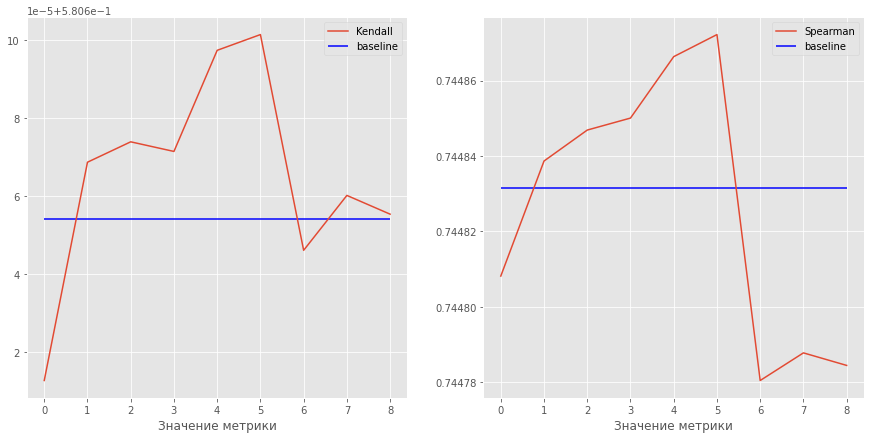

In [55]:
iterations = metrics_history["em_iter"]

fig = plt.figure(figsize=(15, 7))
axes = fig.subplots(1, len(metrics_history) - 1)
for ax_num, metric_name in enumerate(filter(lambda x: x != "em_iter", metrics_history)):
    axes[ax_num].plot(
        iterations, metrics_history[metric_name], label=metric_name)
    axes[ax_num].hlines(baseline[metric_name], 0, max(
        iterations), colors="blue", label="baseline")
    axes[ax_num].legend()
    axes[ax_num].set_xlabel("Итерация EM алгоритма")
    axes[ax_num].set_xlabel("Значение метрики")
    axes[ax_num].grid(True)

# 5 "Рейтинг-лист" турниров по сложности вопросов

In [56]:
weights = torch.load(em_model.best_checkpoint_file(), map_location="cpu")["lin_layer.weight"][0].numpy()

In [57]:
indices = len(skils_encoder.categories_[0]) + questione_complex_encoder.categories_[0]

In [58]:
question_complex = pd.DataFrame({"question_complex": weights[indices]}, index=questione_complex_encoder.categories_[0])
question_complex.index.name = "answer_id"

In [59]:
question_complex.head()

,question_complex
answer_id,
0,2.025927
1,1.062344
2,-0.538246
3,-0.174163
4,1.989074


In [60]:
def question_to_complex(questions_ids, question_complexices):
    complexixes = question_complexices.loc[questions_ids, "question_complex"].to_list()
    complexixes.sort(reverse=True)
    return tuple(complexixes)

In [61]:
tours_with_questios = players[["tour_id", "answer_id"]].groupby("tour_id").apply(lambda x: x["answer_id"].to_list())
tours_with_questios = tours_with_questios.apply(lambda x: question_to_complex(x, question_complex))

In [62]:
tours_with_questios.sort_values(ascending=False, inplace=True)

In [63]:
tours_with_questios.head()

tour_id
5637    (17.020624477123445, 17.020624477123445, 17.02...
6249    (13.733848861766065, 13.733848861766065, 13.73...
6147    (13.335500048192845, 13.335500048192845, 13.33...
5717    (13.316426972387355, 13.316426972387355, 13.31...
5564    (13.14833578571777, 13.14833578571777, 13.1483...
dtype: object

In [64]:
top_n = 10

In [65]:
tours.loc[tours_with_questios.iloc[:top_n].index, ["name", "type"]]

,name,type
tour_id,,
5637,Чемпионат Кыргызстана,"{'id': 2, 'name': 'Обычный'}"
6249,Школьный синхрон-lite. Сезон 3,"{'id': 5, 'name': 'Общий зачёт'}"
6147,Открытый зимний чемпионат ТИУ,"{'id': 2, 'name': 'Обычный'}"
5717,Чемпионат Таджикистана,"{'id': 2, 'name': 'Обычный'}"
5564,Молодёжный чемпионат Нижегородской области,"{'id': 2, 'name': 'Обычный'}"
6008,Малый кубок Физтеха,"{'id': 2, 'name': 'Обычный'}"
6170,Открытый чемпионат Белгородской области,"{'id': 2, 'name': 'Обычный'}"
5590,Межфакультетский кубок МГУ. Отбор №2,"{'id': 2, 'name': 'Обычный'}"
5883,Кубок Профсоюза студентов МГТУ,"{'id': 2, 'name': 'Обычный'}"


In [66]:
tours.loc[tours_with_questios.iloc[-top_n:].index, ["name", "type"]]

,name,type
tour_id,,
5942,Чемпионат Мира. Этап 2. Группа В,"{'id': 2, 'name': 'Обычный'}"
5421,Львов зимой. Адвокат,"{'id': 3, 'name': 'Синхрон'}"
5741,All Cats Are Beautiful,"{'id': 3, 'name': 'Синхрон'}"
5098,"Ра-II: синхрон ""Борского корабела""","{'id': 3, 'name': 'Синхрон'}"
5996,Тихий Донец: омут первый,"{'id': 3, 'name': 'Синхрон'}"
5929,Мемориал памяти Михаила Басса,"{'id': 2, 'name': 'Обычный'}"
5947,Чемпионат Мира. Этап 3. Группа С,"{'id': 2, 'name': 'Обычный'}"
5928,Угрюмый Ёрш,"{'id': 3, 'name': 'Синхрон'}"
5946,Чемпионат Мира. Этап 3. Группа В,"{'id': 2, 'name': 'Обычный'}"


Список турниров сло сложными вопросами получился не совсем интуитивный. В топе пристуствуют как чемпионаты, что ожидаемо так и более локальные соревнования. Возможно, на локальных соревнованиях совсем мало ответов или мало данных, по сравнению с шлобальными соревнованиями. Играют новички, которые плохо на данный момент отвечают на вопросы. В глобальных турнирах собираются команды профессионалов, которые уже имеют определённую подготовку.

Посмотрим на визуализацию ответов команда в этих ткрнирах.

In [67]:
def plot_tour(team_res, tours, tour_id):
    masks = []
    team_ids = []
    for team_id in team_res[tour_id]:
        masks.append(team_res[tour_id][team_id].mask)
        team_ids.append(team_id)
    try:
        fig = plt.figure(figsize=(60, 10))
        ax = fig.add_subplot(111)
        ax.imshow(masks, cmap="gray")
        ax.set_yticks(np.arange(len(team_ids)))
        ax.set_yticklabels(team_ids)
        ax.grid(False)
        ax.grid(True, axis="y")
        ax.set_ylabel("Номер команды")
        ax.set_title(tours.loc[tour_id, "name"])
    except TypeError:
        pass

## Самые сложные турниры

Виуализация отвеов на вопросы. Белый цвет означает, что команда ответила на вопрос. Чёрный что не ответила. 

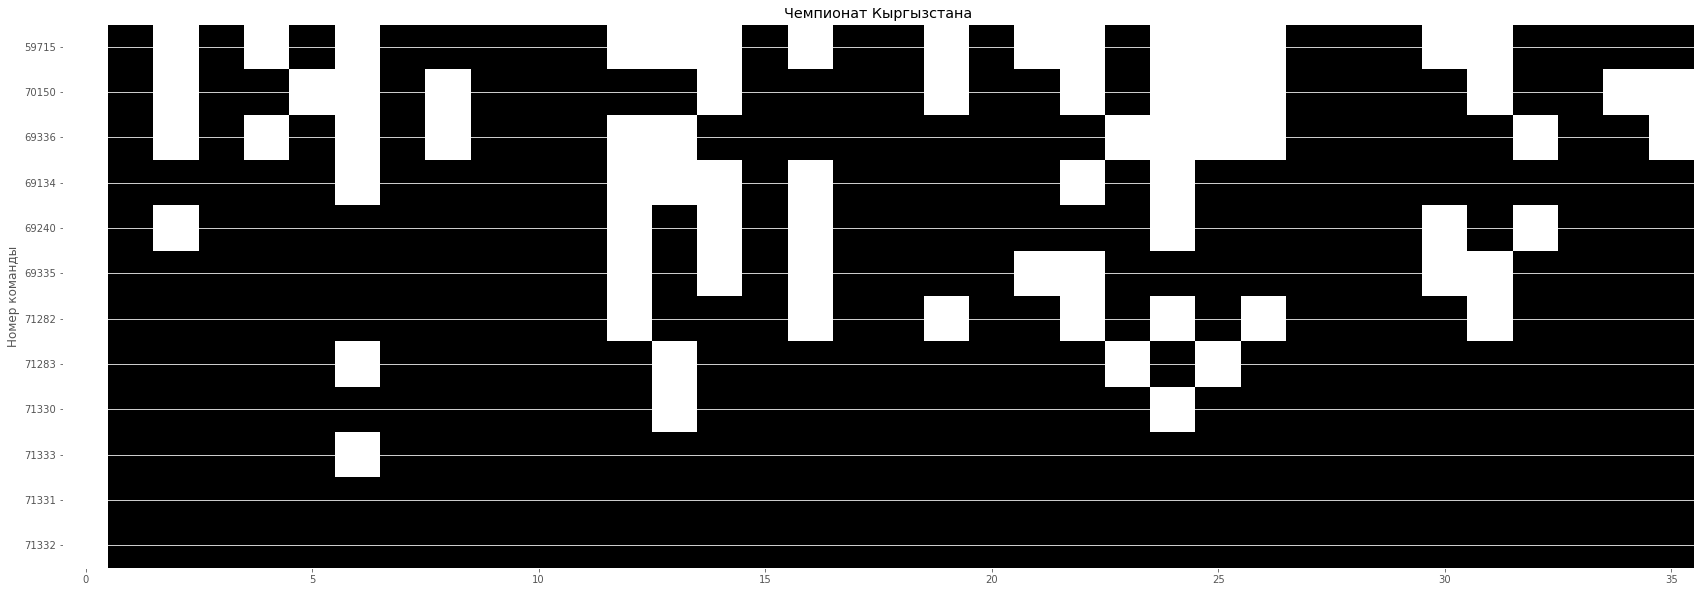

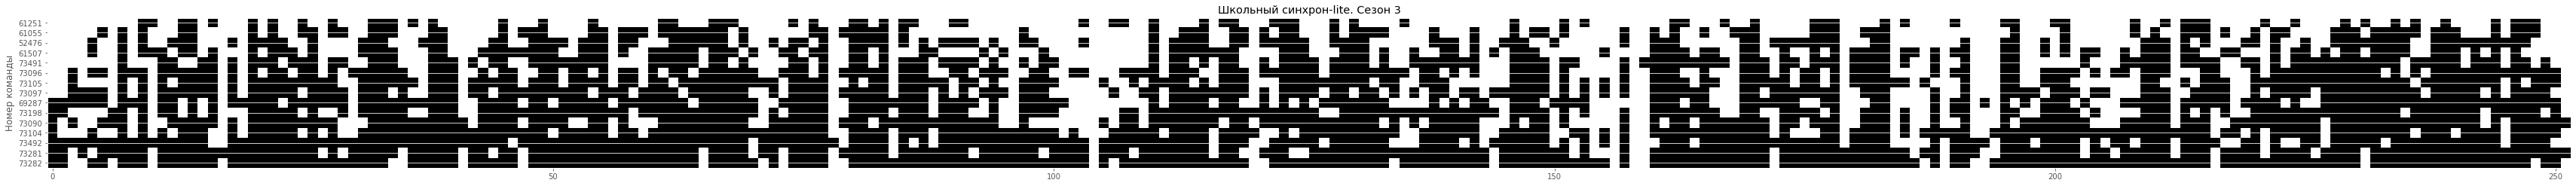

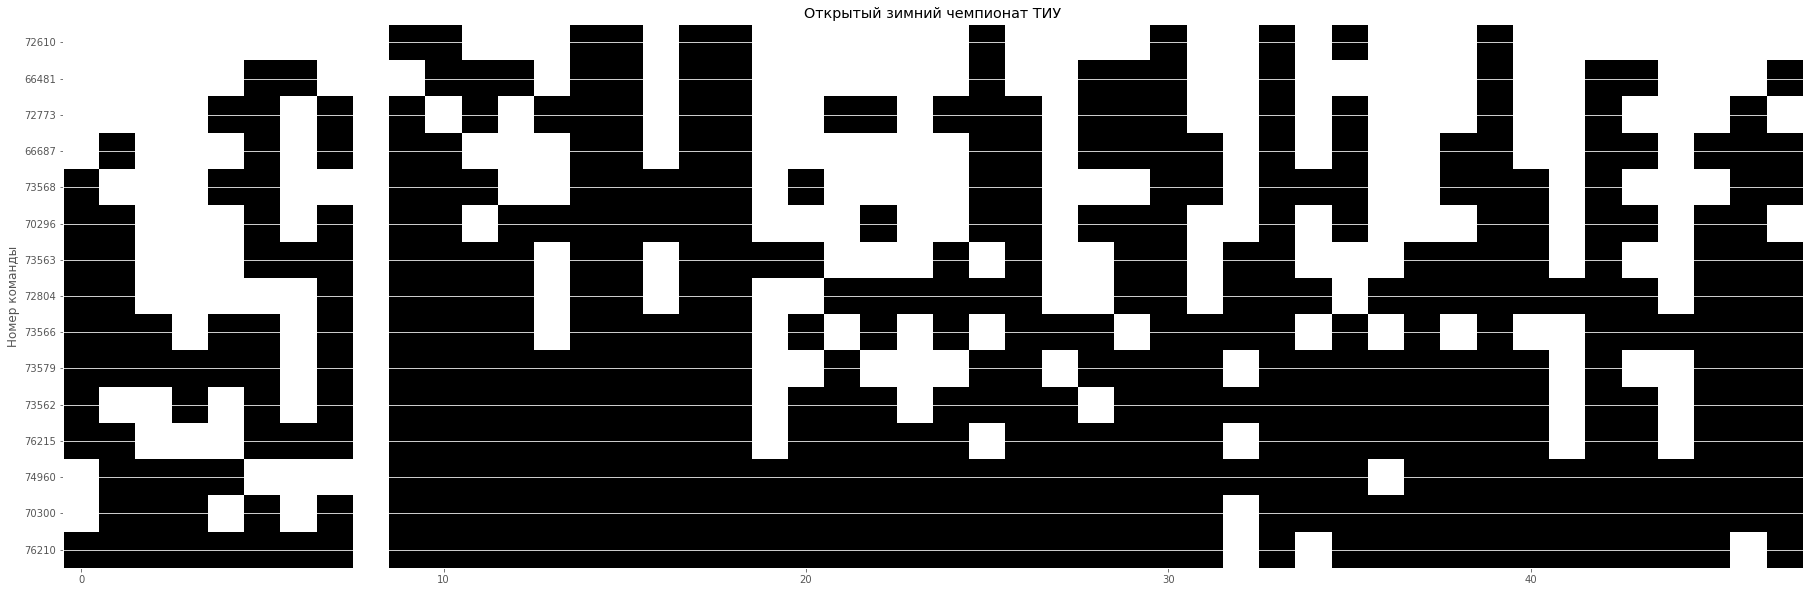

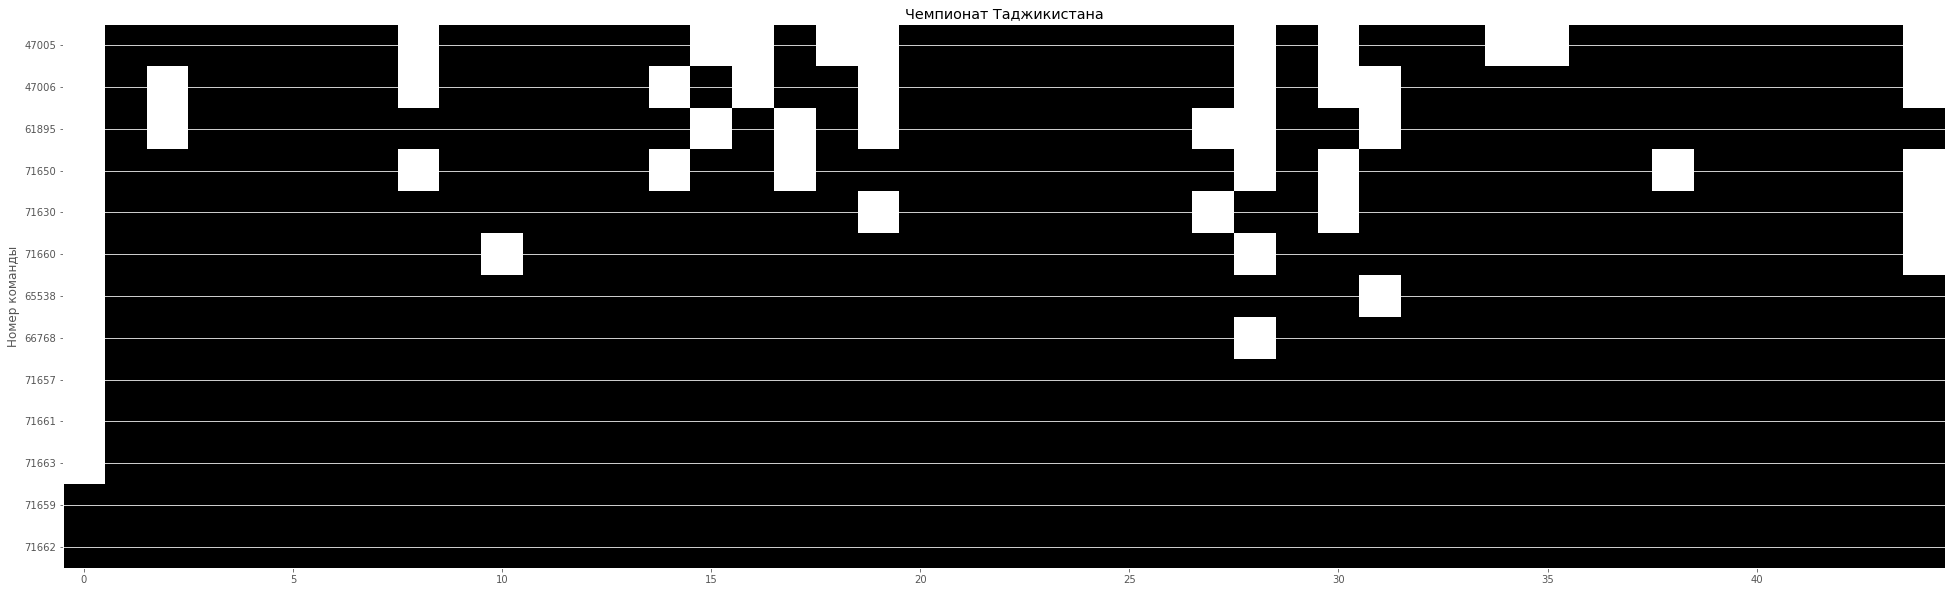

In [68]:
for tour_id in tours_with_questios.iloc[:4].index:
    plot_tour(team_res, tours, tour_id)

## Самые простые турниры

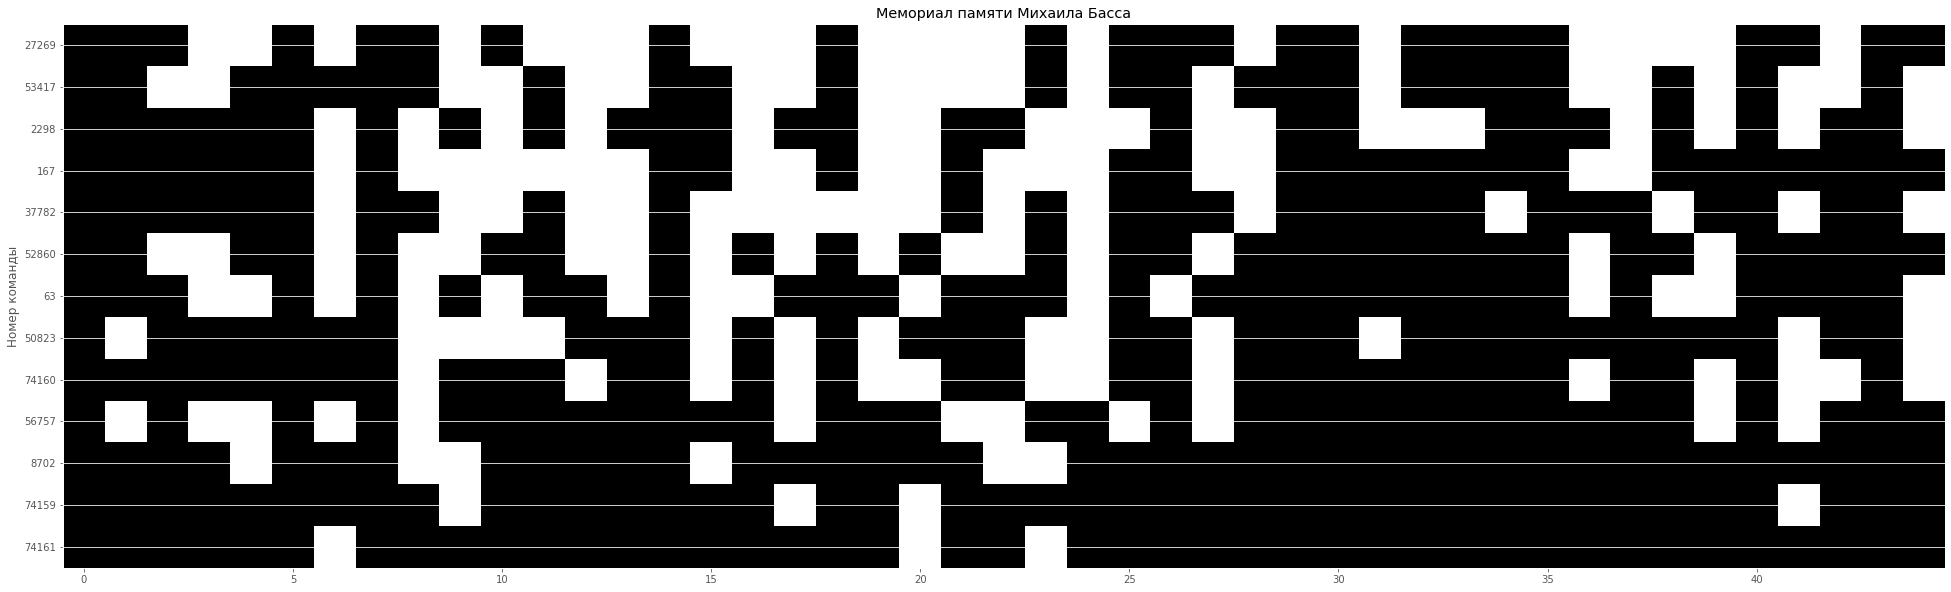

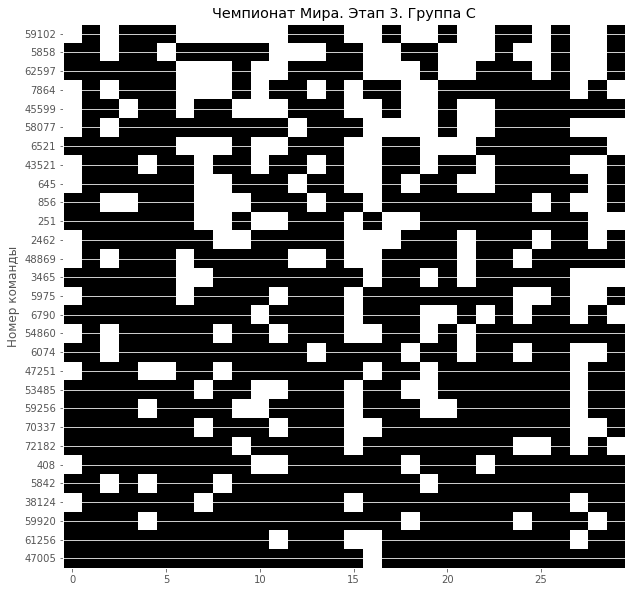

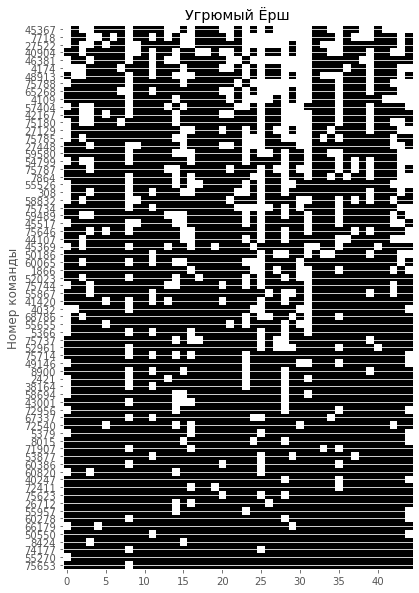

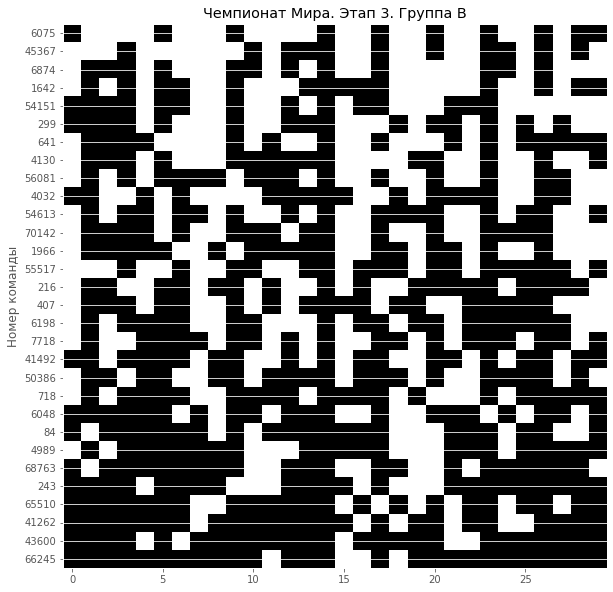

In [69]:
for tour_id in tours_with_questios.iloc[-5:-1].index:
    plot_tour(team_res, tours, tour_id)

# 6 Топ игроков